In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.datasets import (make_classification, make_blobs, load_iris,
                              load_breast_cancer, make_circles, make_moons)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
import time
from sklearn.model_selection import GridSearchCV
import itertools
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin

implementation of the entropic classifier

In [3]:
# objective function

def M_func(lambda_vec, A):

    at_lambda = A.T @ lambda_vec
    N = A.shape[1] - A.shape[0]
    tau = at_lambda[:N]
    zeta = at_lambda[N:]
    val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
    return val

# gradient

def M_grad(lambda_vec, A):

    at_lambda = A.T @ lambda_vec
    N = A.shape[1] - A.shape[0]
    tau = at_lambda[:N]
    zeta = at_lambda[N:]
    dtau = (np.exp(tau) - np.exp(-tau)) / (np.exp(-tau) + np.exp(tau))
    dzeta = np.exp(zeta)
    grad_at_lambda = np.concatenate([dtau, dzeta])
    grad_lambda = A @ grad_at_lambda
    return grad_lambda

# solving lambda

def solve_lambda(A, lambda_init=None, max_iter=5000, tol=1e-6, initial_step_size=1.0,
                 c=1e-4, beta=0.5):

    M = A.shape[0]
    if lambda_init is None:
        lambda_init = np.zeros(M)

    lam = lambda_init.copy()
    g = M_grad(lam, A)
    grad_norm = np.linalg.norm(g)

    if grad_norm < tol:
        return lam

    alpha = initial_step_size
    lam_old = lam
    g_old = g
    f_old = M_func(lam, A)

    for k in range(max_iter):

        d = -g

        if k > 0:
            s = lam - lam_old
            y = g - g_old
            sy = s @ y
            ss = s @ s
            if sy > 1e-14:
                alpha = ss / sy
            else:
                alpha = initial_step_size

        while True:
            lam_new = lam + alpha * d
            f_new = M_func(lam_new, A)
            if f_new <= f_old + c * alpha * (g @ d):
                break
            alpha *= beta
            if alpha < 1e-14:
                break

        lam_old = lam
        g_old = g
        lam = lam_new
        f_old = f_new
        g = M_grad(lam, A)
        grad_norm = np.linalg.norm(g)

        if grad_norm < tol:
            return lam

    print("Warning: Optimization did not converge within the maximum number of iterations.")
    return lam

# computing w and b

def compute_w_b(A, lambda_star):

    M = A.shape[0]
    N = A.shape[1] - M
    D = A[:, :N]
    Dt_lambda = D.T @ lambda_star
    num_w = -np.exp(-Dt_lambda) + np.exp(Dt_lambda)
    den_w = np.exp(-Dt_lambda) + np.exp(Dt_lambda)
    w = num_w / den_w
    b = np.exp(-lambda_star)
    return w, b

# fitting the entropic classifier

def entropic_classifier_fit(G, D):

    G = np.asarray(G)
    D = np.asarray(D)
    K1, N = G.shape
    K2 = D.shape[0]
    M = K1 + K2
    D_matrix = np.vstack([G, -D])
    A = np.hstack([D_matrix, -np.eye(M)])
    lambda_star = solve_lambda(A)
    w, b = compute_w_b(A, lambda_star)
    G_scores = G @ w
    D_scores = D @ w

    b_plus = np.min(G_scores)
    b_minus = np.min(-D_scores)
    threshold = (b_plus + b_minus) / 2.0

    return w, b, threshold, b_plus, b_minus

# predicting class

def entropic_classifier_predict(X, w, b, threshold):

    scores = X @ w
    y_pred = np.where(scores > threshold, 0, 1)
    return y_pred

class EntropicClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):

        pass

    def fit(self, X, y):

        X = np.asarray(X)
        y = np.asarray(y)
        G = X[y == 0]
        D = X[y == 1]
        self.w_, self.b_, self.threshold_, self.b_plus_, self.b_minus_ = entropic_classifier_fit(G, D)
        return self

    def predict(self, X):

        X = np.asarray(X)
        scores = X @ self.w_
        return np.where(scores > self.threshold_, 0, 1)

    def decision_function(self, X):

        X = np.asarray(X)
        return X @ self.w_

plotting

In [4]:
def plot_decision_boundaries(X_train_sc, y_train, X_test_sc, y_test,
                             w_ent, threshold_ent, b_plus_ent, b_minus_ent,
                             w_mon, threshold_mon, b_plus_mon, b_minus_mon,
                             models, dataset_name, chosen_degree=None):

    if X_train_sc.shape[1] != 2:
        print(f"Decision boundaries not plotted for {dataset_name} (requires 2D features).")
        return

    x_min, x_max = X_train_sc[:, 0].min() - 1, X_train_sc[:, 0].max() + 1
    y_min, y_max = X_train_sc[:, 1].min() - 1, X_train_sc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    total_plots = len(models) + 1
    n_cols = 3
    n_rows = int(np.ceil(total_plots / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axs = axs.flatten()

    blue_mask = (y_test == 0)
    red_mask = (y_test == 1)

    scores_ent = grid @ w_ent
    Z_ent = np.where(scores_ent > threshold_ent, 0, 1).reshape(xx.shape)
    axs[0].contourf(xx, yy, Z_ent, alpha=0.3, cmap='coolwarm')
    Z_plus_ent = np.where(scores_ent > b_plus_ent, 0, 1).reshape(xx.shape)
    Z_minus_ent = np.where(scores_ent > b_minus_ent, 0, 1).reshape(xx.shape)
    axs[0].contour(xx, yy, Z_plus_ent, levels=[0.5], colors='green', linestyles='--', linewidths=1.5)
    axs[0].contour(xx, yy, Z_minus_ent, levels=[0.5], colors='green', linestyles='--', linewidths=1.5)
    axs[0].scatter(X_test_sc[blue_mask, 0], X_test_sc[blue_mask, 1],
                   c='blue', marker='s', edgecolors='k', label='Class 0')
    axs[0].scatter(X_test_sc[red_mask, 0], X_test_sc[red_mask, 1],
                   c='red', marker='o', edgecolors='k', label='Class 1')
    axs[0].set_title("Entropic Linear")

    if hasattr(models["Monomial Classifier"], "decision_function"):
        scores_mon = models["Monomial Classifier"].decision_function(grid)
    else:
        scores_mon = models["Monomial Classifier"].predict_proba(grid)[:, 1]
    Z_mon = np.where(scores_mon > threshold_mon, 0, 1).reshape(xx.shape)
    axs[1].contourf(xx, yy, Z_mon, alpha=0.3, cmap='coolwarm')
    Z_plus_mon = np.where(scores_mon > b_plus_mon, 0, 1).reshape(xx.shape)
    Z_minus_mon = np.where(scores_mon > b_minus_mon, 0, 1).reshape(xx.shape)
    axs[1].contour(xx, yy, Z_plus_mon, levels=[0.5], colors='purple', linestyles='--', linewidths=1.5)
    axs[1].contour(xx, yy, Z_minus_mon, levels=[0.5], colors='purple', linestyles='--', linewidths=1.5)
    axs[1].scatter(X_test_sc[blue_mask, 0], X_test_sc[blue_mask, 1],
                   c='blue', marker='s', edgecolors='k', label='Class 0')
    axs[1].scatter(X_test_sc[red_mask, 0], X_test_sc[red_mask, 1],
                   c='red', marker='o', edgecolors='k', label='Class 1')
    if chosen_degree is not None:
        axs[1].set_title(f"Entropic Polynomial (Degree: {chosen_degree})")
    else:
        axs[1].set_title("Entropic Polynomial")

    idx = 2
    for name, model in models.items():
        if name in ["Entropic Classifier", "Monomial Classifier"]:
            continue
        if hasattr(model, "decision_function"):
            scores = model.decision_function(grid)
        else:
            scores = model.predict_proba(grid)[:, 1]
        Z = np.where(scores > 0.5, 0, 1).reshape(xx.shape)
        axs[idx].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        axs[idx].scatter(X_test_sc[blue_mask, 0], X_test_sc[blue_mask, 1],
                         c='blue', marker='s', edgecolors='k', label='Class 0')
        axs[idx].scatter(X_test_sc[red_mask, 0], X_test_sc[red_mask, 1],
                         c='red', marker='o', edgecolors='k', label='Class 1')
        axs[idx].set_title(name)
        idx += 1

    for j in range(idx, len(axs)):
        axs[j].axis('off')

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(f"Decision Boundaries on {dataset_name} with Uncertainty Bands", fontsize=16)
    plt.tight_layout()
    plt.show()

benchmarking function

In [5]:
def benchmark_dataset(X, y, dataset_name="Dataset"):

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    # entropic classifier timing and metrics
    start = time.time()
    G_train = X_train_sc[y_train == 0]
    D_train = X_train_sc[y_train == 1]
    w_ent, b_ent, threshold_ent, b_plus_ent, b_minus_ent = entropic_classifier_fit(G_train, D_train)
    y_pred_ent = entropic_classifier_predict(X_test_sc, w_ent, b_ent, threshold_ent)
    ent_time = time.time() - start

    ent_acc = accuracy_score(y_test, y_pred_ent)
    ent_precision = precision_score(y_test, y_pred_ent, pos_label=1, zero_division=0)
    ent_recall = recall_score(y_test, y_pred_ent, pos_label=1, zero_division=0)
    ent_f1 = f1_score(y_test, y_pred_ent, pos_label=1, zero_division=0)
    ent_cm = confusion_matrix(y_test, y_pred_ent)

    # grid search for SVM
    param_grid_svm = {
        'C': [0.1, 1],
        'kernel': ['linear']
    }
    start = time.time()
    svm_gs = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, scoring='accuracy')
    svm_gs.fit(X_train_sc, y_train)
    svm_clf = svm_gs.best_estimator_
    y_pred_svm = svm_clf.predict(X_test_sc)
    svm_time = time.time() - start

    svm_acc = accuracy_score(y_test, y_pred_svm)
    svm_precision = precision_score(y_test, y_pred_svm, pos_label=1, zero_division=0)
    svm_recall = recall_score(y_test, y_pred_svm, pos_label=1, zero_division=0)
    svm_f1 = f1_score(y_test, y_pred_svm, pos_label=1, zero_division=0)
    svm_cm = confusion_matrix(y_test, y_pred_svm)

    # grid search for KNN
    param_grid_knn = {
        'n_neighbors': [1],
        'weights': ['uniform', 'distance']
    }
    start = time.time()
    knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='accuracy')
    knn_gs.fit(X_train_sc, y_train)
    knn_clf = knn_gs.best_estimator_
    y_pred_knn = knn_clf.predict(X_test_sc)
    knn_time = time.time() - start

    knn_acc = accuracy_score(y_test, y_pred_knn)
    knn_precision = precision_score(y_test, y_pred_knn, pos_label=1, zero_division=0)
    knn_recall = recall_score(y_test, y_pred_knn, pos_label=1, zero_division=0)
    knn_f1 = f1_score(y_test, y_pred_knn, pos_label=1, zero_division=0)
    knn_cm = confusion_matrix(y_test, y_pred_knn)

    # logistic regression timing and metrics
    start = time.time()
    log_clf = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_sc, y_train)
    y_pred_log = log_clf.predict(X_test_sc)
    log_time = time.time() - start
    log_acc = accuracy_score(y_test, y_pred_log)
    log_precision = precision_score(y_test, y_pred_log, pos_label=1, zero_division=0)
    log_recall = recall_score(y_test, y_pred_log, pos_label=1, zero_division=0)
    log_f1 = f1_score(y_test, y_pred_log, pos_label=1, zero_division=0)
    log_cm = confusion_matrix(y_test, y_pred_log)

    # perceptron timing and metrics
    start = time.time()
    perc_clf = Perceptron(random_state=42).fit(X_train_sc, y_train)
    y_pred_perc = perc_clf.predict(X_test_sc)
    perc_time = time.time() - start
    perc_acc = accuracy_score(y_test, y_pred_perc)
    perc_precision = precision_score(y_test, y_pred_perc, pos_label=1, zero_division=0)
    perc_recall = recall_score(y_test, y_pred_perc, pos_label=1, zero_division=0)
    perc_f1 = f1_score(y_test, y_pred_perc, pos_label=1, zero_division=0)
    perc_cm = confusion_matrix(y_test, y_pred_perc)

    # entropic polynomial classifier 
    base_pipeline = Pipeline([
        ('poly_features', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('entropic_classifier', EntropicClassifier())
    ])
    param_grid_poly = {'poly_features__degree': [2, 3, 4]}
    grid_search_poly = GridSearchCV(base_pipeline, param_grid_poly, cv=3, scoring='accuracy')
    start = time.time()
    grid_search_poly.fit(X_train_sc, y_train)
    monomial_pipeline = grid_search_poly.best_estimator_
    y_pred_monomial = monomial_pipeline.predict(X_test_sc)
    monomial_time = time.time() - start

    monomial_acc = accuracy_score(y_test, y_pred_monomial)
    monomial_precision = precision_score(y_test, y_pred_monomial, pos_label=1, zero_division=0)
    monomial_recall = recall_score(y_test, y_pred_monomial, pos_label=1, zero_division=0)
    monomial_f1 = f1_score(y_test, y_pred_monomial, pos_label=1, zero_division=0)
    monomial_cm = confusion_matrix(y_test, y_pred_monomial)

    # extract uncertainty band parameters from our entropic classifier in the pipeline
    ent_poly_clf = monomial_pipeline.named_steps['entropic_classifier']
    threshold_mon = ent_poly_clf.threshold_
    b_plus_mon = ent_poly_clf.b_plus_
    b_minus_mon = ent_poly_clf.b_minus_

    # get the chosen polynomial degree
    chosen_degree = monomial_pipeline.named_steps['poly_features'].degree

    print(f"\n=== Results on {dataset_name} ===")

    # entropic classifier metrics
    print("\nEntropic Classifier:")
    print(f"  Accuracy: {ent_acc:.2f}")
    print(f"  Precision: {ent_precision:.2f}")
    print(f"  Recall: {ent_recall:.2f}")
    print(f"  F1-Score: {ent_f1:.2f}")
    print("  Confusion Matrix:")
    print(ent_cm)
    print(f"  Runtime: {ent_time:.4f} seconds")

    # SVM metrics
    print("\nSVM (with GridSearch):")
    print(f"  Best Params: {svm_gs.best_params_}")
    print(f"  Accuracy: {svm_acc:.2f}")
    print(f"  Precision: {svm_precision:.2f}")
    print(f"  Recall: {svm_recall:.2f}")
    print(f"  F1-Score: {svm_f1:.2f}")
    print("  Confusion Matrix:")
    print(svm_cm)
    print(f"  Runtime: {svm_time:.4f} seconds")

    # KNN metrics
    print("\nKNN (with GridSearch):")
    print(f"  Best Params: {knn_gs.best_params_}")
    print(f"  Accuracy: {knn_acc:.2f}")
    print(f"  Precision: {knn_precision:.2f}")
    print(f"  Recall: {knn_recall:.2f}")
    print(f"  F1-Score: {knn_f1:.2f}")
    print("  Confusion Matrix:")
    print(knn_cm)
    print(f"  Runtime: {knn_time:.4f} seconds")

    # logistic regression metrics
    print("\nLogistic Regression:")
    print(f"  Accuracy: {log_acc:.2f}")
    print(f"  Precision: {log_precision:.2f}")
    print(f"  Recall: {log_recall:.2f}")
    print(f"  F1-Score: {log_f1:.2f}")
    print("  Confusion Matrix:")
    print(log_cm)
    print(f"  Runtime: {log_time:.4f} seconds")

    # perceptron metrics
    print("\nPerceptron:")
    print(f"  Accuracy: {perc_acc:.2f}")
    print(f"  Precision: {perc_precision:.2f}")
    print(f"  Recall: {perc_recall:.2f}")
    print(f"  F1-Score: {perc_f1:.2f}")
    print("  Confusion Matrix:")
    print(perc_cm)
    print(f"  Runtime: {perc_time:.4f} seconds")

    # polynomial classifier metrics
    print("\nMonomial Classifier (Best Degree Chosen):")
    print(f"  Degree: {chosen_degree}")
    print(f"  Accuracy: {monomial_acc:.2f}")
    print(f"  Precision: {monomial_precision:.2f}")
    print(f"  Recall: {monomial_recall:.2f}")
    print(f"  F1-Score: {monomial_f1:.2f}")
    print("  Confusion Matrix:")
    print(monomial_cm)
    print(f"  Runtime: {monomial_time:.4f} seconds")

    # prepare models for plotting
    models_for_plot = {
        "SVM": svm_clf,
        "LogReg": log_clf,
        "Perceptron": perc_clf,
        "1-NN": knn_clf,
        "Monomial Classifier": monomial_pipeline
    }

   # plot decision boundaries with uncertainty bands
    plot_decision_boundaries(
        X_train_sc, y_train, X_test_sc, y_test,
        w_ent, threshold_ent, b_plus_ent, b_minus_ent,
        w_mon=None,
        threshold_mon=threshold_mon,
        b_plus_mon=b_plus_mon,
        b_minus_mon=b_minus_mon,
        models=models_for_plot,
        dataset_name=dataset_name,
        chosen_degree=chosen_degree
    )

datasets

In [6]:
# linearly separable synthetic data
X_linsep, y_linsep = make_blobs(n_samples=500, centers=2, n_features=2, random_state=42, cluster_std=1.5)

# breast cancer dataset
bc = load_breast_cancer()
X_bc, y_bc = bc.data, bc.target

# spiral dataset
def generate_spiral(n_samples, noise=0.1):
    theta = np.sqrt(np.random.rand(n_samples)) * 2 * np.pi
    r_a = 2*theta + np.pi
    r_b = -2*theta - np.pi
    data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
    data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
    Xs = np.vstack([data_a, data_b])
    ys = np.hstack([np.zeros(n_samples), np.ones(n_samples)])
    Xs += noise * np.random.normal(size=Xs.shape)
    return Xs, ys

X_spiral, y_spiral = generate_spiral(500, noise=0.1)

# circles dataset (non-linear)
X_circles, y_circles = make_circles(n_samples=500, factor=0.5, noise=0.1, random_state=42)

# moons dataset
X_moons, y_moons = make_moons(n_samples=500, noise=0.1, random_state=42)

# high-dimensional dataset
X_hd, y_hd = make_classification(n_samples=500, n_features=40, n_informative=10,
                                 n_redundant=20, random_state=42)

results

/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))



=== Results on Breast Cancer ===

Entropic Classifier:
  Accuracy: 0.94
  Precision: 0.99
  Recall: 0.91
  F1-Score: 0.95
  Confusion Matrix:
[[62  1]
 [10 98]]
  Runtime: 0.8156 seconds

SVM (with GridSearch):
  Best Params: {'C': 0.1, 'kernel': 'linear'}
  Accuracy: 0.98
  Precision: 0.98
  Recall: 0.99
  F1-Score: 0.99
  Confusion Matrix:
[[ 61   2]
 [  1 107]]
  Runtime: 0.0104 seconds

KNN (with GridSearch):
  Best Params: {'n_neighbors': 1, 'weights': 'uniform'}
  Accuracy: 0.95
  Precision: 0.95
  Recall: 0.97
  F1-Score: 0.96
  Confusion Matrix:
[[ 58   5]
 [  3 105]]
  Runtime: 0.0395 seconds

Logistic Regression:
  Accuracy: 0.98
  Precision: 0.99
  Recall: 0.98
  F1-Score: 0.99
  Confusion Matrix:
[[ 62   1]
 [  2 106]]
  Runtime: 0.0067 seconds

Perceptron:
  Accuracy: 0.98
  Precision: 0.99
  Recall: 0.98
  F1-Score: 0.99
  Confusion Matrix:
[[ 62   1]
 [  2 106]]
  Runtime: 0.0009 seconds

Monomial Classifier (Best Degree Chosen):
  Degree: 2
  Accuracy: 0.92
  Precision

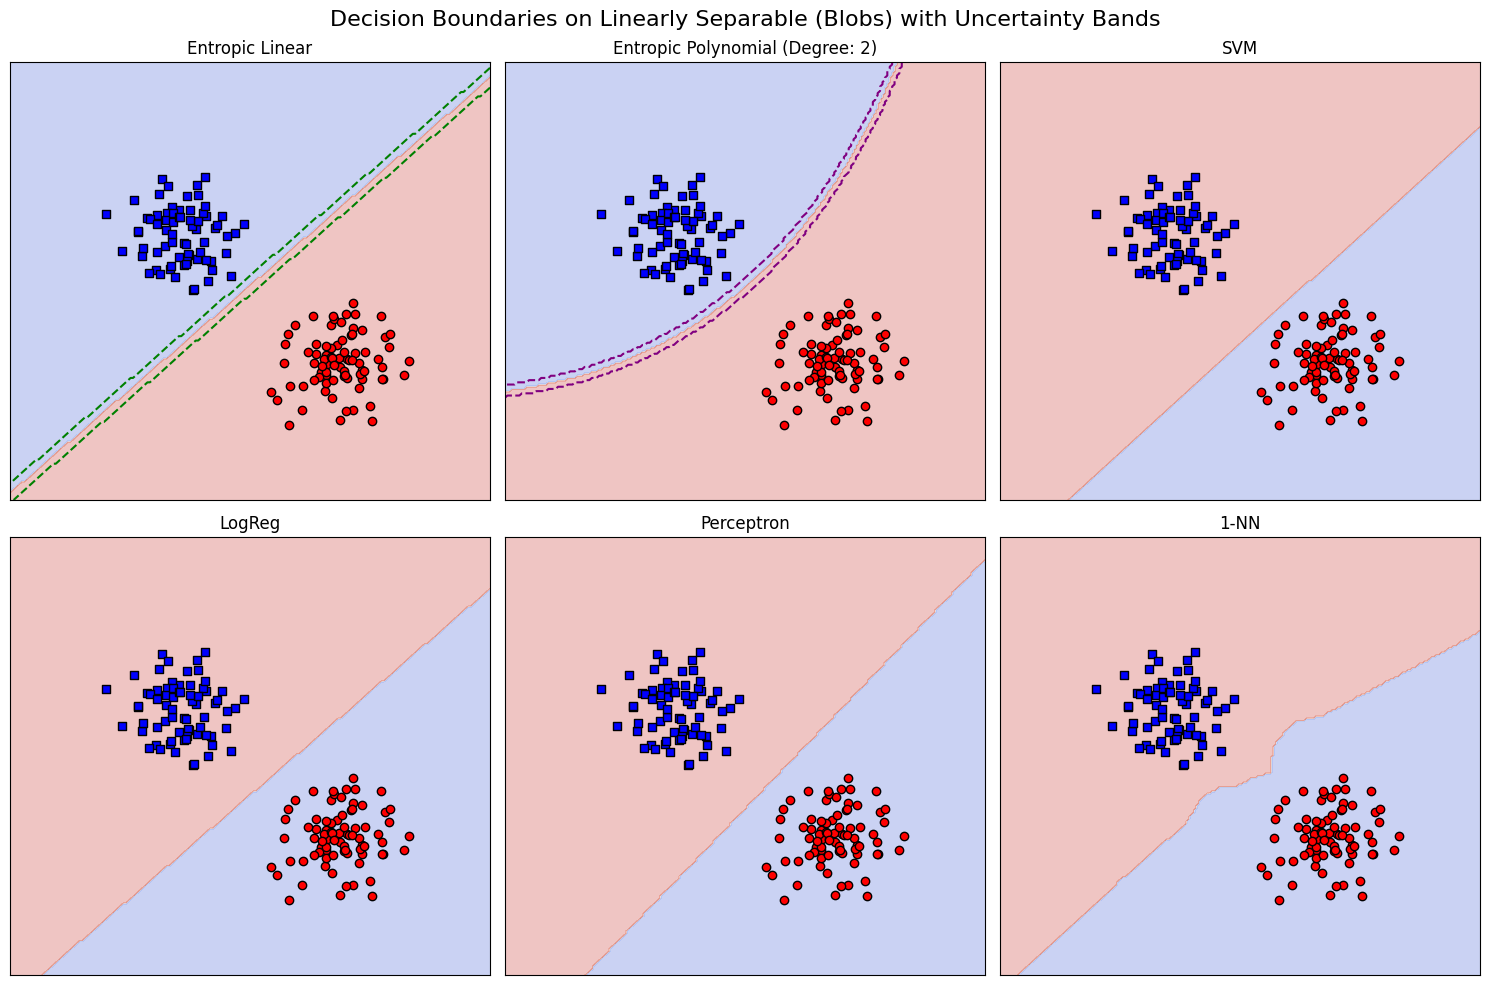

/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))



=== Results on Non-linearly Separable (Circles) ===

Entropic Classifier:
  Accuracy: 0.46
  Precision: 0.00
  Recall: 0.00
  F1-Score: 0.00
  Confusion Matrix:
[[69  6]
 [75  0]]
  Runtime: 0.6723 seconds

SVM (with GridSearch):
  Best Params: {'C': 1, 'kernel': 'linear'}
  Accuracy: 0.53
  Precision: 0.52
  Recall: 0.64
  F1-Score: 0.57
  Confusion Matrix:
[[31 44]
 [27 48]]
  Runtime: 0.0122 seconds

KNN (with GridSearch):
  Best Params: {'n_neighbors': 1, 'weights': 'uniform'}
  Accuracy: 0.97
  Precision: 1.00
  Recall: 0.93
  F1-Score: 0.97
  Confusion Matrix:
[[75  0]
 [ 5 70]]
  Runtime: 0.0130 seconds

Logistic Regression:
  Accuracy: 0.49
  Precision: 0.49
  Recall: 0.48
  F1-Score: 0.48
  Confusion Matrix:
[[37 38]
 [39 36]]
  Runtime: 0.0008 seconds

Perceptron:
  Accuracy: 0.57
  Precision: 0.55
  Recall: 0.76
  F1-Score: 0.64
  Confusion Matrix:
[[28 47]
 [18 57]]
  Runtime: 0.0008 seconds

Monomial Classifier (Best Degree Chosen):
  Degree: 4
  Accuracy: 0.99
  Precisio

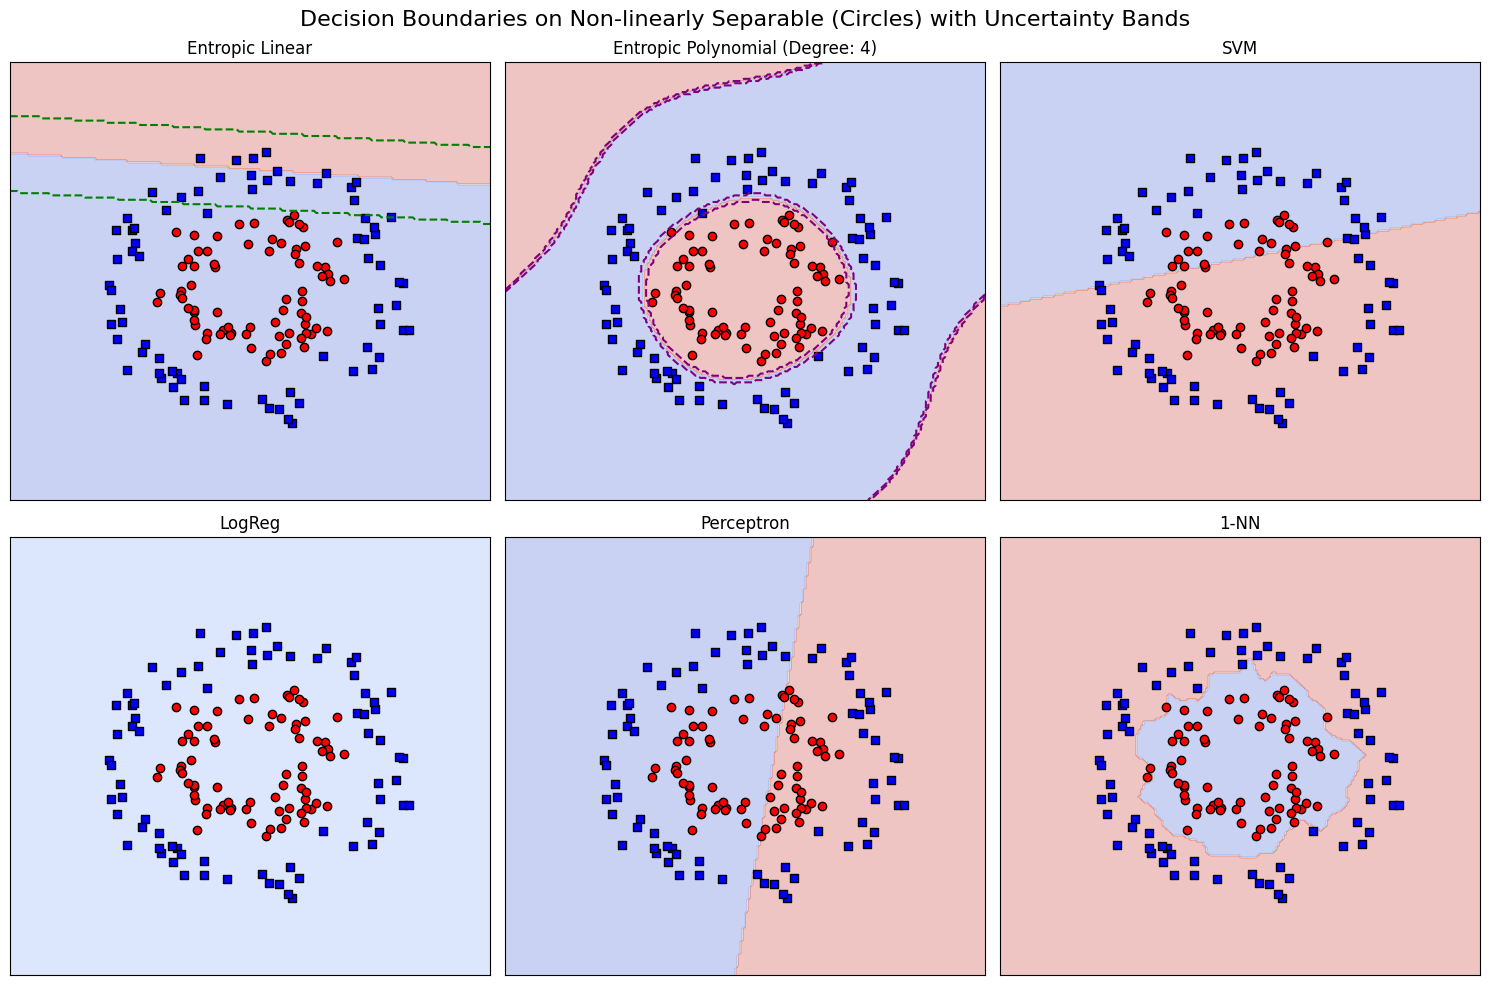

/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))



=== Results on Spiral Dataset ===

Entropic Classifier:
  Accuracy: 0.72
  Precision: 1.00
  Recall: 0.44
  F1-Score: 0.61
  Confusion Matrix:
[[150   0]
 [ 84  66]]
  Runtime: 1.5290 seconds

SVM (with GridSearch):
  Best Params: {'C': 1, 'kernel': 'linear'}
  Accuracy: 0.75
  Precision: 0.75
  Recall: 0.76
  F1-Score: 0.75
  Confusion Matrix:
[[112  38]
 [ 36 114]]
  Runtime: 0.0245 seconds

KNN (with GridSearch):
  Best Params: {'n_neighbors': 1, 'weights': 'uniform'}
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Confusion Matrix:
[[150   0]
 [  0 150]]
  Runtime: 0.0196 seconds

Logistic Regression:
  Accuracy: 0.75
  Precision: 0.75
  Recall: 0.77
  F1-Score: 0.76
  Confusion Matrix:
[[111  39]
 [ 35 115]]
  Runtime: 0.0009 seconds

Perceptron:
  Accuracy: 0.62
  Precision: 0.66
  Recall: 0.51
  F1-Score: 0.58
  Confusion Matrix:
[[110  40]
 [ 73  77]]
  Runtime: 0.0008 seconds

Monomial Classifier (Best Degree Chosen):
  Degree: 3
  Accuracy: 0.99
  Precis

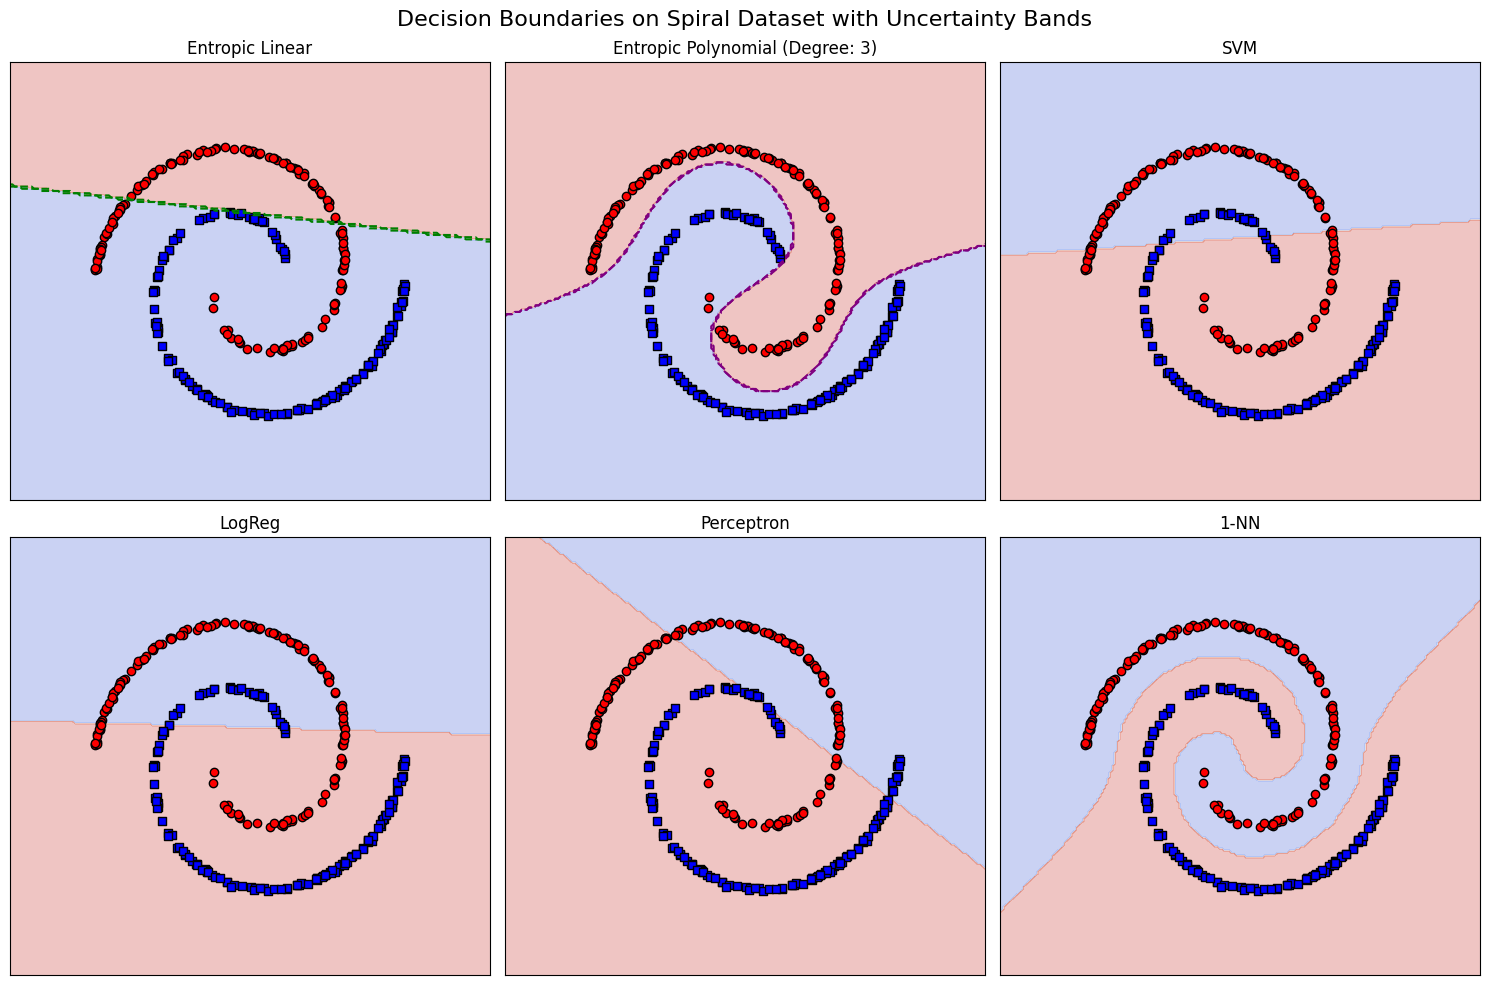

/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))
/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))


/var/folders/10/mfk3_2cx0579b9z2m9g_tzym0000gn/T/ipykernel_20976/2195023585.py:9: RuntimeWarning: overflow encountered in exp
  val = np.sum(np.log(np.exp(-tau) + np.exp(tau))) + np.sum(np.exp(zeta))



=== Results on Moons Dataset ===

Entropic Classifier:
  Accuracy: 0.80
  Precision: 1.00
  Recall: 0.60
  F1-Score: 0.75
  Confusion Matrix:
[[75  0]
 [30 45]]
  Runtime: 0.5952 seconds

SVM (with GridSearch):
  Best Params: {'C': 1, 'kernel': 'linear'}
  Accuracy: 0.88
  Precision: 0.88
  Recall: 0.88
  F1-Score: 0.88
  Confusion Matrix:
[[66  9]
 [ 9 66]]
  Runtime: 0.0097 seconds

KNN (with GridSearch):
  Best Params: {'n_neighbors': 1, 'weights': 'uniform'}
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Confusion Matrix:
[[75  0]
 [ 0 75]]
  Runtime: 0.0139 seconds

Logistic Regression:
  Accuracy: 0.88
  Precision: 0.88
  Recall: 0.88
  F1-Score: 0.88
  Confusion Matrix:
[[66  9]
 [ 9 66]]
  Runtime: 0.0009 seconds

Perceptron:
  Accuracy: 0.87
  Precision: 0.88
  Recall: 0.87
  F1-Score: 0.87
  Confusion Matrix:
[[66  9]
 [10 65]]
  Runtime: 0.0005 seconds

Monomial Classifier (Best Degree Chosen):
  Degree: 3
  Accuracy: 0.99
  Precision: 1.00
  Recall: 0

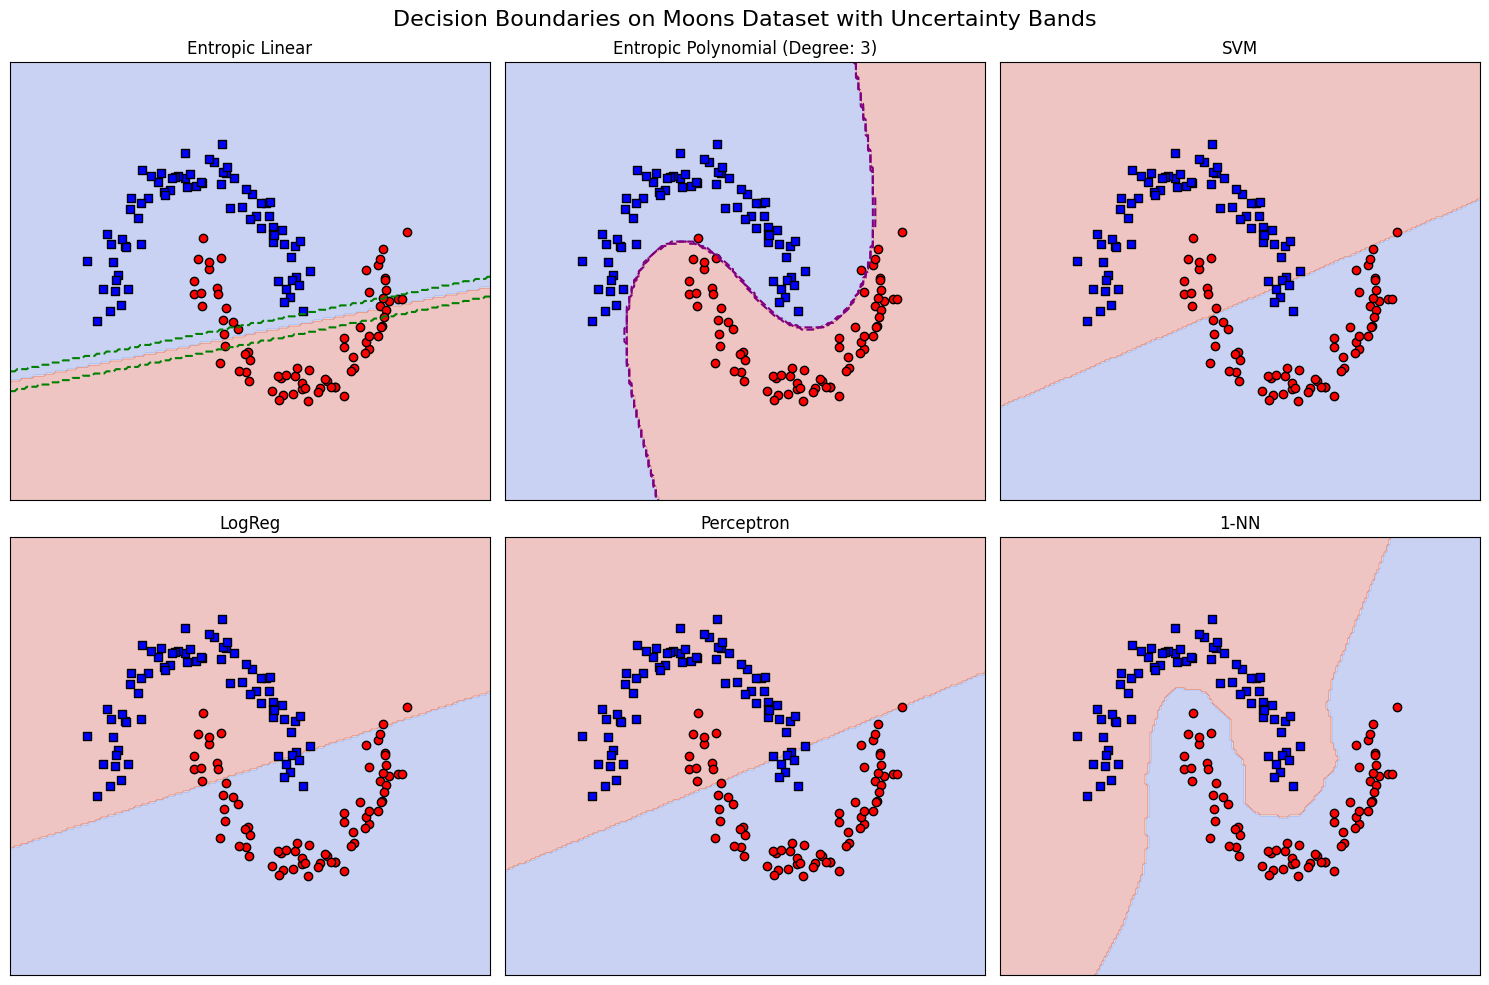

In [7]:
if __name__ == "__main__":
    # breast cancer dataset
    benchmark_dataset(X_bc, y_bc, dataset_name="Breast Cancer")
    # simple linear dataset
    benchmark_dataset(X_linsep, y_linsep, dataset_name="Linearly Separable (Blobs)")

    # non-linear dataset (circles)
    benchmark_dataset(X_circles, y_circles, dataset_name="Non-linearly Separable (Circles)")

    # spiral dataset
    benchmark_dataset(X_spiral, y_spiral, dataset_name="Spiral Dataset")

    # moons dataset
    benchmark_dataset(X_moons, y_moons, dataset_name="Moons Dataset")

    # high-dimensional redundant data
    #benchmark_dataset(X_hd, y_hd, dataset_name="High-Dimensional Redundant Data")
    #benchmark_dataset(X, y, dataset_name="Multi Features")